<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit5/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

## Leverage

Let's take a look at the full basketball data set.

In [3]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

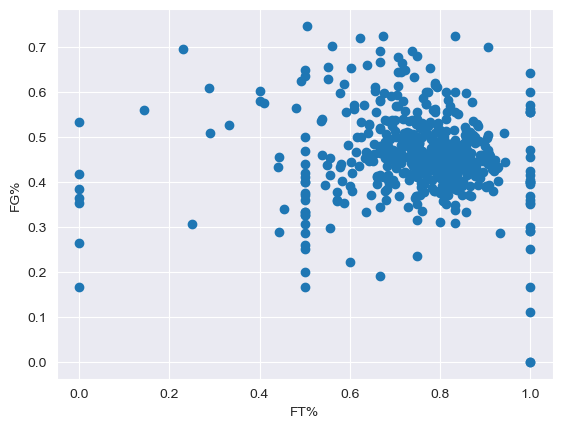

In [6]:
plt.scatter(basketball['FT%'], basketball['FG%'])
plt.xlabel('FT%')
plt.ylabel('FG%')

**Answer1**:

The clump looks almost identical to the one from class, but with more data points. However, there are notably far more data points precisely at the 0% FT% mark, 50%, and 100%. These are almost certainly from players who have had little play time, and thus few free throws. This is likely why they were removed in the first place. Other than that, when focusing solely on the clump, the trend appears negative: as FT% increases, FG% decreases.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [7]:
# copy from the AK B)

pos_idx = basketball.Pos.cat.codes.values
pos_codes = basketball.Pos.cat.categories
bb_coords = {"pos": pos_codes}

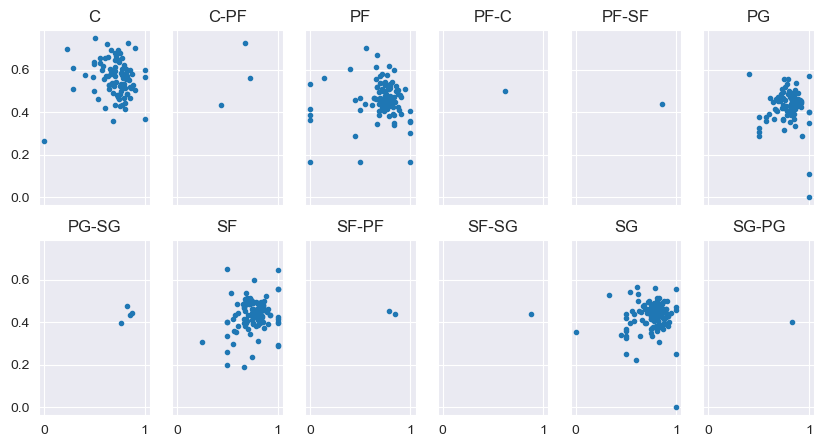

In [8]:
# even more copying

_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Answer2**:

All of the plots appear shifted up, because there are more outliers in the lower regions of FG%. This is likely due to the same reason as the outliers in the first plot: players with little play time. This 'squishing' decreases the negative trend seen in the original plotting. This is particularly evident in the C and PF plots. When only looking at the clump in these plots, you can still see the downward trend, but when taking the outliers into account, it is far less pronounced. 

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

**Answer3**:

Looking at the graphs above, I certainly won't be trying to make my own model. The data looks more like a cloud than a line, and the outliers are far too numerous. While there is a vague negative trend if you look closely enough, and only at the central clump, the overall data is not linear, and thus a linear model will not work. To use the language from the notes, there are numerous quite horizontal lines that could be drawn through the data set, and even some with a positive trend; the model will have an extremely hard time finding that negative slope.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [9]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [10]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'Weight')

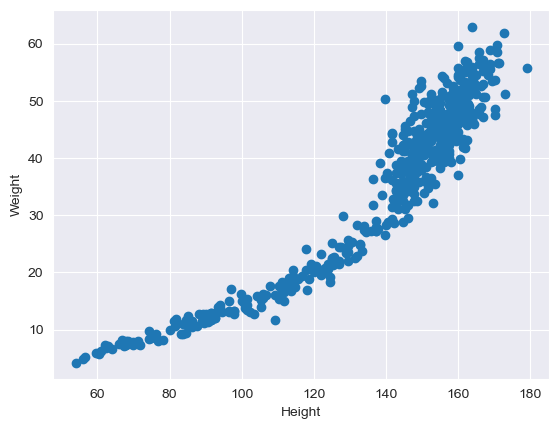

In [11]:
plt.scatter(howell['height'], howell['weight'])
plt.xlabel('Height')
plt.ylabel('Weight')


**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [39]:
with pm.Model() as model_howell:
    α = pm.HalfNormal("α", sigma=10) # positive support, mean 0
    β = pm.Gamma("β", mu=0.33, sigma=0.3) # positive support, mean of ~0.3 (anticipated slope looking at graph)

    γ = pm.Gamma("γ", mu=8, sigma=5) # positive support, mean of low number
    δ = pm.Gamma("δ", mu=5, sigma=4) # positive support, mean of ~5

    μ = pm.Deterministic("μ", α + β * howell.height)
    σ = pm.Deterministic("σ", γ + δ * howell.height)

    y = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)
    
    idata_howell = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


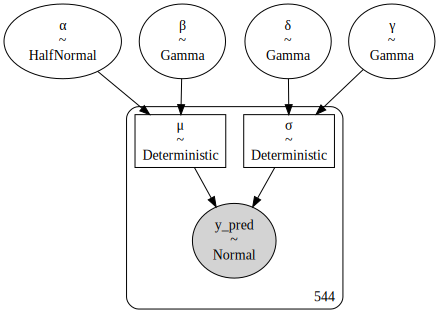

In [43]:
pm.model_to_graphviz(model_howell)

Text(0, 0.5, 'weight')

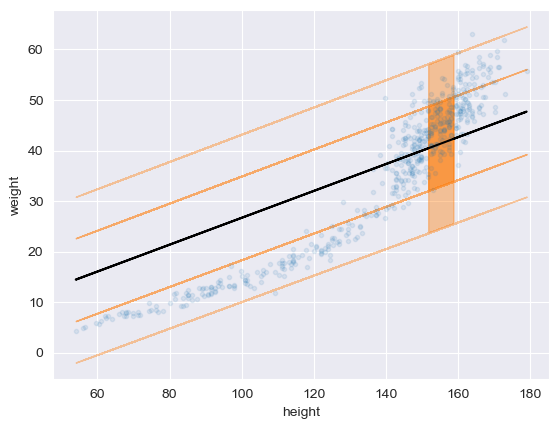

In [40]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_howell = az.extract(idata_howell)

μ_m = posterior_howell["μ"].mean("sample").values
σ_m = posterior_howell["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

Sampling: [y_pred]


<Axes: xlabel='y_pred'>

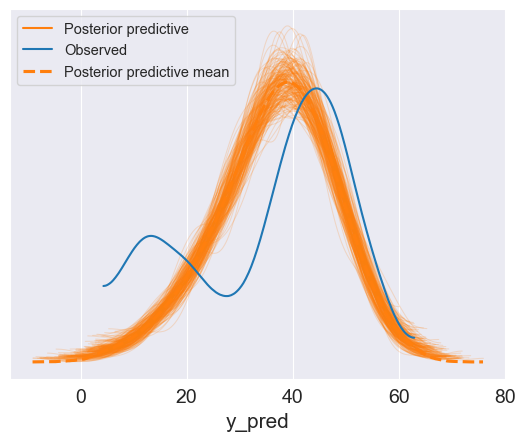

In [41]:
pm.sample_posterior_predictive(idata_howell, model=model_howell, extend_inferencedata=True)
az.plot_ppc(idata_howell, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Answer6**:

This isn't too good. It completely misses the mode of the data, and the spread is far too large. On the plus side, it doesn't predict anything impossible like negative weights. Looking at the posterior visualization from Task5, it did as well as it could given we forced it to be a straight line, but it most definitely will do far better as a GLM. It also doesn't help that the data appears somewhat bimodal, though the central mode appears to be relatively normal which is nice.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [70]:
with pm.Model() as model_howell_glm:
    α = pm.HalfNormal("α", sigma=10) # positive support, mean 0
    β = pm.Gamma("β", mu=0.33, sigma=0.3) # positive support, mean of ~0.3 (anticipated slope looking at graph)

    γ = pm.Gamma("γ", mu=8, sigma=5) # positive support, mean of low number
    δ = pm.Gamma("δ", mu=5, sigma=4) # positive support, mean of ~5
    
    μ = pm.Deterministic("μ", α + β * pm.math.sqr(howell.height))
    σ = pm.Deterministic("σ", γ + δ * pm.math.sqr(howell.height))

    y = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howell_glm = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0, 0.5, 'weight')

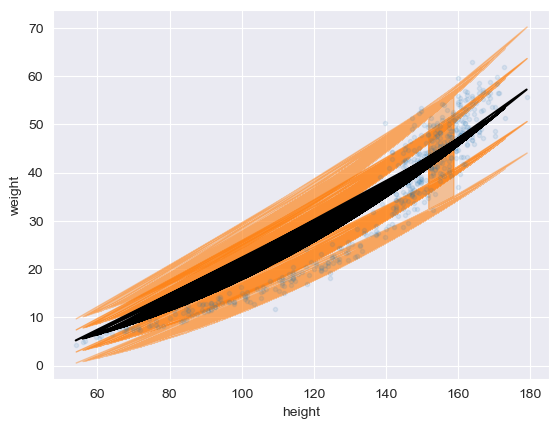

In [71]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_howell = az.extract(idata_howell_glm)

μ_m = posterior_howell["μ"].mean("sample").values
σ_m = posterior_howell["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Sampling: [y_pred]


<Axes: xlabel='y_pred'>

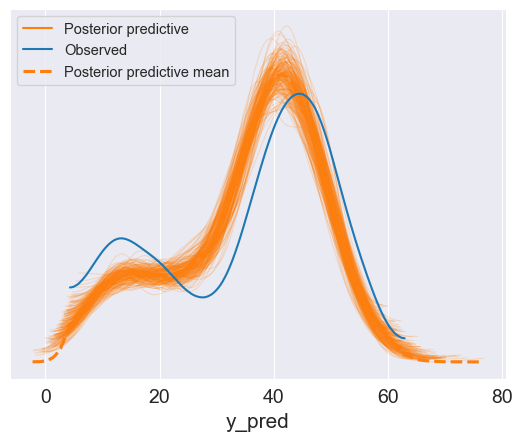

In [72]:
pm.sample_posterior_predictive(idata_howell_glm, model=model_howell_glm, extend_inferencedata=True)
az.plot_ppc(idata_howell_glm, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Answer8**:

This already does so much better. The primary mode is mostly captured, with the peak and standard deviation seeming fairly accurate. The mode is a little offset, which may be partly due to the bimodal nature of the data. Speaking of which, it also does notice that mode, though it doesn't really capture it. This is a huge improvement over the straight linear model, though could certainly be improved further were this my project. The square term likely is correct, as it mostly captures the data's shape.